<h1 class="font-effect-3d" style="font-family:Ewert; font-size:150%; color:#39d4be;"> Code Modules, Functions, Styling, and Links</h1>

#### [GitHub Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP2) & [Colaboratory Version](https://colab.research.google.com/drive/1Z9Fz0OOi6bpWvH-H2OhExC9CkGPWBYZz)

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Roboto|Ewert&effect=3d');
span {font-family:Roboto; color:black; text-shadow:4px 4px 4px #aaa;}  
a,h4,div.output_area pre{font-family:Roboto; font-size:120%; color:#39d4be;}      
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl 
import os,h5py
from skimage.transform import resize
fpath='../input/classification-of-handwritten-letters/'
print(os.listdir("../input"))

['classification-of-handwritten-letters', 'vgg19', 'resnet50', 'vgg16']


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19,preprocess_input as vgg19pi
from keras.applications.vgg16 import VGG16,preprocess_input as vgg16pi
from keras.applications.resnet50 import ResNet50,preprocess_input as resnet50pi
from keras.applications.resnet_v2 import ResNet152V2,preprocess_input as preiRN
from keras import __version__; print('keras version:', __version__)
from sklearn import __version__; print('sklearn version:', __version__)

Using TensorFlow backend.


keras version: 2.3.1
sklearn version: 0.22.2.post1


In [4]:
def ohe(x): 
    out=OneHotEncoder(categories='auto').fit(x.reshape(-1,1))
    return out.transform(x.reshape(-1,1)).toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def history_plot(fit_history):
    keys=list(fit_history.history.keys())[0:4]
    pl.figure(figsize=(12,10)); pl.subplot(211)
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#39d4be',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#39d4be',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid(); pl.title('Accuracy'); pl.show()

<h1 class="font-effect-3d" style="font-family:Ewert; font-size:150%; color:#39d4be;"> Preprocessing the Data </h1>

In [5]:
f=h5py.File(fpath+'LetterColorImages_123.h5','r')
keys=list(f.keys()); keys 

['backgrounds', 'images', 'labels']

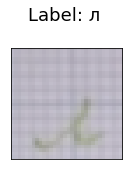

In [6]:
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
images=np.array(f[keys[1]])/255
labels=np.array(f[keys[2]])
pl.figure(figsize=(2,3)); il=10**4
pl.xticks([]); pl.yticks([])
pl.title('Label: %s \n'%letters[labels[il]-1],
         fontsize=18)
pl.imshow(images[il]); pl.show()

In [7]:
clabels=ohe(labels)
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,clabels)
sh=[el.shape for el in \
[clabels,x_train1,y_train1,x_valid1,y_valid1,x_test1,y_test1]]
pd.DataFrame(sh).T

,0,1,2,3,4,5,6
0,14190.0,11352.0,11352.0,1419.0,1419.0,1419.0,1419.0
1,33.0,32.0,33.0,32.0,33.0,32.0,33.0
2,NaN,32.0,NaN,32.0,NaN,32.0,NaN
3,NaN,3.0,NaN,3.0,NaN,3.0,NaN


<h1 class="font-effect-3d" style="font-family:Ewert; font-size:150%; color:#39d4be;"> Classification Models </h1>
#### VGG16

In [8]:
fw='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_base_model=VGG16(weights=fw,include_top=False)
pvx_train1=vgg16_base_model.predict(x_train1)
pvx_valid1=vgg16_base_model.predict(x_valid1)
pvx_test1=vgg16_base_model.predict(x_test1)
pvx_train1=pvx_train1.reshape(-1,1,1,pvx_train1.shape[3])
pvx_valid1=pvx_valid1.reshape(-1,1,1,pvx_valid1.shape[3])
pvx_test1=pvx_test1.reshape(-1,1,1,pvx_test1.shape[3])

In [9]:
sh=pvx_train1.shape[1:]
def vgg16_model():
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))    
    model.add(Dense(33,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
vgg16_model=vgg16_model()

In [10]:
checkpointer=ModelCheckpoint(filepath='weights.best.hdf5',verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
vgg16_history=\
vgg16_model.fit(pvx_train1,y_train1,
                validation_data=(pvx_valid1,y_valid1),
                epochs=100,batch_size=128,verbose=2,
                callbacks=[checkpointer,lr_reduction,estopping]);

Train on 11352 samples, validate on 1419 samples
Epoch 1/100
 - 2s - loss: 3.3211 - accuracy: 0.0797 - val_loss: 2.8161 - val_accuracy: 0.2276

Epoch 00001: val_loss improved from inf to 2.81607, saving model to weights.best.hdf5
Epoch 2/100
 - 2s - loss: 2.7759 - accuracy: 0.1866 - val_loss: 2.3613 - val_accuracy: 0.3249

Epoch 00002: val_loss improved from 2.81607 to 2.36127, saving model to weights.best.hdf5
Epoch 3/100
 - 2s - loss: 2.4562 - accuracy: 0.2635 - val_loss: 2.1218 - val_accuracy: 0.3650

Epoch 00003: val_loss improved from 2.36127 to 2.12180, saving model to weights.best.hdf5
Epoch 4/100
 - 2s - loss: 2.2807 - accuracy: 0.3081 - val_loss: 2.0048 - val_accuracy: 0.3827

Epoch 00004: val_loss improved from 2.12180 to 2.00476, saving model to weights.best.hdf5
Epoch 5/100
 - 2s - loss: 2.1460 - accuracy: 0.3492 - val_loss: 1.9017 - val_accuracy: 0.4257

Epoch 00005: val_loss improved from 2.00476 to 1.90173, saving model to weights.best.hdf5
Epoch 6/100
 - 2s - loss: 2.03

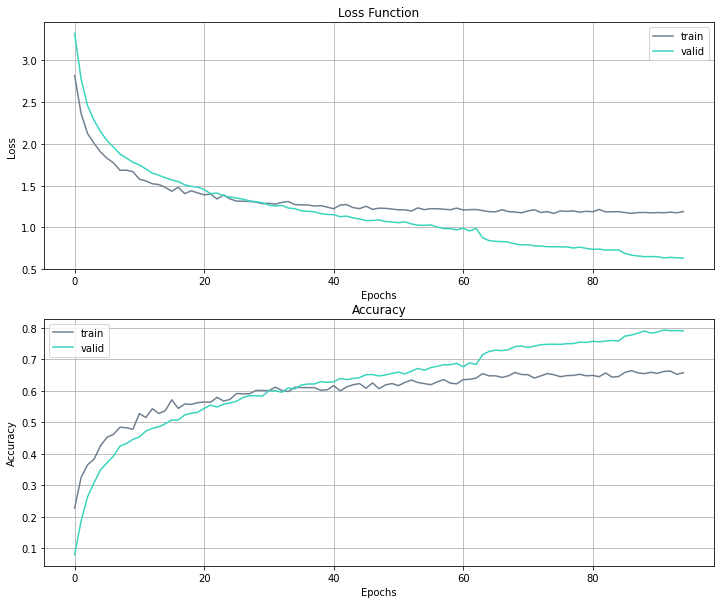

1419/1419 [==============================] - 0s 86us/step
Accuracy: 63.28%


[1.2748045590328785, 0.6328400373458862]

In [11]:
history_plot(vgg16_history)
vgg16_model.load_weights('weights.best.hdf5')
vgg16_scores=vgg16_model.evaluate(pvx_test1,y_test1)
print("Accuracy: %.2f%%"%(vgg16_scores[1]*100))
vgg16_scores

#### VGG 19

In [12]:
fw='../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg19bmodel=VGG19(weights=fw,include_top=False)
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,clabels)
pvx_train1=vgg19bmodel.predict(x_train1)
pvx_valid1=vgg19bmodel.predict(x_valid1)
pvx_test1=vgg19bmodel.predict(x_test1)
pvx_train1=pvx_train1.reshape(-1,1,1,pvx_train1.shape[3])
pvx_valid1=pvx_valid1.reshape(-1,1,1,pvx_valid1.shape[3])
pvx_test1=pvx_test1.reshape(-1,1,1,pvx_test1.shape[3])

In [13]:
sh=pvx_train1.shape[1:]
def vgg19_model():
    model = Sequential() 
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(33,activation='softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
vgg19_model=vgg19_model()

In [14]:
checkpointer=ModelCheckpoint(filepath='weights.best.hdf5',
                             verbose=2,save_best_only=True)
reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                            verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
vgg19_history=\
vgg19_model.fit(pvx_train1,y_train1, 
                validation_data=(pvx_valid1,y_valid1),
                epochs=150,batch_size=128,verbose=2,
                callbacks=[checkpointer,lr_reduction,estopping]);

Train on 11352 samples, validate on 1419 samples
Epoch 1/150
 - 2s - loss: 3.4533 - accuracy: 0.0539 - val_loss: 3.2541 - val_accuracy: 0.0980

Epoch 00001: val_loss improved from inf to 3.25405, saving model to weights.best.hdf5
Epoch 2/150
 - 2s - loss: 3.1774 - accuracy: 0.1086 - val_loss: 2.8460 - val_accuracy: 0.2185

Epoch 00002: val_loss improved from 3.25405 to 2.84598, saving model to weights.best.hdf5
Epoch 3/150
 - 2s - loss: 2.8714 - accuracy: 0.1631 - val_loss: 2.5502 - val_accuracy: 0.2629

Epoch 00003: val_loss improved from 2.84598 to 2.55022, saving model to weights.best.hdf5
Epoch 4/150
 - 2s - loss: 2.6748 - accuracy: 0.2049 - val_loss: 2.3751 - val_accuracy: 0.3023

Epoch 00004: val_loss improved from 2.55022 to 2.37512, saving model to weights.best.hdf5
Epoch 5/150
 - 2s - loss: 2.5233 - accuracy: 0.2374 - val_loss: 2.2576 - val_accuracy: 0.3397

Epoch 00005: val_loss improved from 2.37512 to 2.25761, saving model to weights.best.hdf5
Epoch 6/150
 - 2s - loss: 2.41

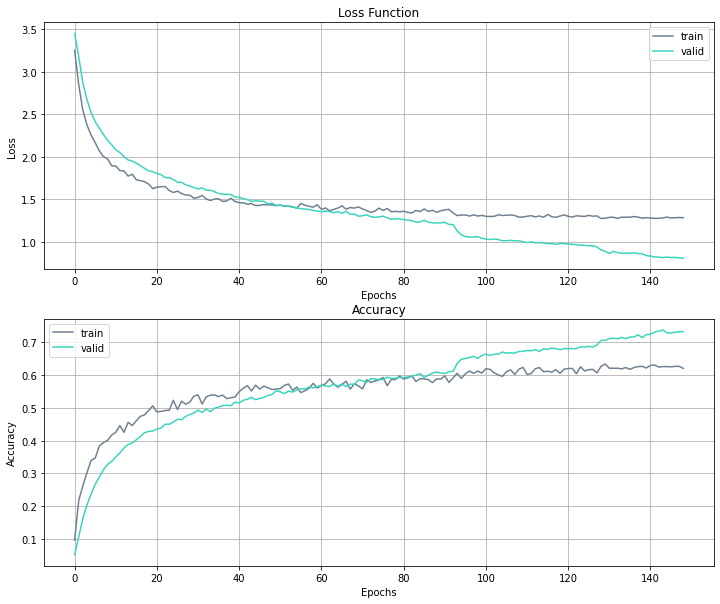

1419/1419 [==============================] - 0s 86us/step
Accuracy: 59.13%


[1.4123797092410861, 0.5912614464759827]

In [15]:
history_plot(vgg19_history)
vgg19_model.load_weights('weights.best.hdf5')
vgg19_scores=vgg19_model.evaluate(pvx_test1,y_test1)
print("Accuracy: %.2f%%"%(vgg19_scores[1]*100))
vgg19_scores

#### ResNet152V2

In [16]:
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,clabels)
RNbmodel=ResNet152V2(weights='imagenet',include_top=False)
pvx_train1=RNbmodel.predict(x_train1)
pvx_valid1=RNbmodel.predict(x_valid1)
pvx_test1=RNbmodel.predict(x_test1)
pvx_train1=pvx_train1.reshape(-1,1,1,pvx_train1.shape[3])
pvx_valid1=pvx_valid1.reshape(-1,1,1,pvx_valid1.shape[3])
pvx_test1=pvx_test1.reshape(-1,1,1,pvx_test1.shape[3])

234553344/234545216 [==============================] - 3s 0us/step


In [17]:
sh=pvx_train1.shape[1:]
def RNmodel():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25)) 
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))        
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))   
    model.add(Dense(33,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
RNmodel=RNmodel()

In [18]:
checkpointer=ModelCheckpoint(filepath='weights.best.hdf5',
                             verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=RNmodel.fit(pvx_train1,y_train1, 
                    validation_data=(pvx_valid1,y_valid1), 
                    epochs=100,batch_size=128,verbose=2, 
                    callbacks=[checkpointer,lr_reduction,estopping]);

Train on 11352 samples, validate on 1419 samples
Epoch 1/100
 - 5s - loss: 3.2206 - accuracy: 0.1098 - val_loss: 2.8788 - val_accuracy: 0.1910

Epoch 00001: val_loss improved from inf to 2.87885, saving model to weights.best.hdf5
Epoch 2/100
 - 5s - loss: 2.8283 - accuracy: 0.1887 - val_loss: 2.6295 - val_accuracy: 0.2431

Epoch 00002: val_loss improved from 2.87885 to 2.62954, saving model to weights.best.hdf5
Epoch 3/100
 - 5s - loss: 2.6042 - accuracy: 0.2395 - val_loss: 2.4682 - val_accuracy: 0.2960

Epoch 00003: val_loss improved from 2.62954 to 2.46817, saving model to weights.best.hdf5
Epoch 4/100
 - 5s - loss: 2.4458 - accuracy: 0.2800 - val_loss: 2.4344 - val_accuracy: 0.2903

Epoch 00004: val_loss improved from 2.46817 to 2.43437, saving model to weights.best.hdf5
Epoch 5/100
 - 6s - loss: 2.3135 - accuracy: 0.3115 - val_loss: 2.3970 - val_accuracy: 0.2946

Epoch 00005: val_loss improved from 2.43437 to 2.39695, saving model to weights.best.hdf5
Epoch 6/100
 - 5s - loss: 2.20

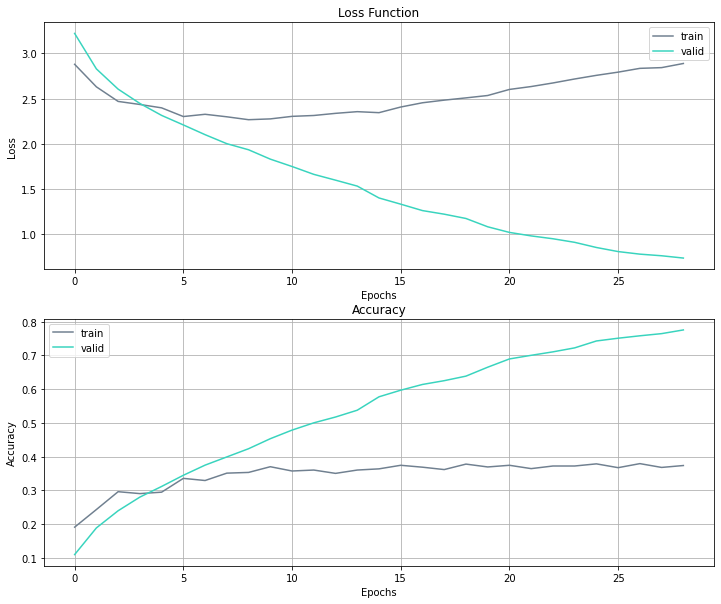

1419/1419 [==============================] - 0s 200us/step
Accuracy: 30.80%


[2.3515626431519587, 0.3079633414745331]

In [19]:
history_plot(history)
RNmodel.load_weights('weights.best.hdf5')
RNscores=RNmodel.evaluate(pvx_test1,y_test1)
print("Accuracy: %.2f%%"%(RNscores[1]*100))
RNscores